# Final Project for course 42577 Introduction to Business Analytics

## 1. Introduction

This project topic is the housing market. It is is responsible for a significant part of the economy of any country. In this case, the country of study is Chile and more concretely Santiago de Chile, the capital and largest city of the country. There are a lot of companies and people interested on understanding the insights of the housing market. Investors, real state agencies or even average people, risk big amounts of money on these decisions that require a wise analysis.

Frequently, a neighbourhood is evaluated by its safety, schools or good communication, but this will take this into another level of analysis. This is because of the possibility of adding an immense amount of characteristics that a regular person is not able to evaluate easily.

Throughout this project, the dataset will be analyzed to understanding how Business Analytics can help on the comprehension of the market, in order to predict the household type. 

### Imports

In [1]:
#imports 
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

%matplotlib inline
import matplotlib.pyplot as plt

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

Using TensorFlow backend.


### Get data and fix index

In [2]:
data = pd.read_excel('Households Data.xlsx') #loan the data
data = data.set_index('Hogar') #we will use the house id as index

The data consists of some information about the house transactions and the household that bought the house.
As we want to predict the type of household, we will delete all the related data. Therefore, our data will contain information about the accessibility and characteristics of the areas where they are, distances to different transport modes and the location of the house. The location was given to us in UTM coordinates, that we have transformed to geographic coordinates using an excel sheet given by [Ingeomatic](https://www.youtube.com/watch?v=sy9SjW3RTN8&t=74s).

In [3]:
#delete data related to household type and utm coordenates
data = data[data.EXCLUIR == 0]
drops = ['paraValidacion', 'IngresoHogar', 'Factor', 'AnosEstudio', 'DirCoordX', 'DirCoordY', 'EXCLUIR']
data = data.drop(drops, axis=1)
data.head()

Sector  MontoArr  CLASE  Sup_Prom_Constr_Hab_EOD  Calid_EOD_norm_inv  \
Hogar                                                                          
100010       7    100000      1                     53.8                0.98   
100020       7    120000      1                     59.6                0.98   
100030       7     70000      1                     59.5                0.98   
100041       7     80000      2                     59.5                0.98   
100052       7    117771      2                     43.6                0.98   

        DensConstr_EOD  Dist_est_Metro_MC_KM  Dist_salida_Autop_MC_KM  \
Hogar                                                                   
100010           0.059             23.051711                 4.345179   
100020           0.033             21.080177                 1.381521   
100030           0.004             34.147894                11.993389   
100041           0.004             34.147817                11.993268   
100052           0.086             19.908792                 1.363177   

        Tiempo_Com_Stgo  Ingreso_Promedio_Zona_MM  ...  \
Hogar                                              ...   
100010               69                  0.519765  ...   
100020               84                  0.678317  ...   
100030               83                  0.408158  ...   
100041               83                  0.408158  ...   
100052               94                  0.498140  ...   

        Acc_Servicios_tpte_pub  Acc_Comercio_auto  Acc_Educacion_auto  \
Hogar                                                                   
100010               719.84272            3036.41             1781.81   
100020               719.84272            3036.41             1781.81   
100030               719.84272            3036.41             1781.81   
100041               719.84272            3036.41             1781.81   
100052               719.84272            3036.41             1781.81   

        Acc_Habitacion_auto  Acc_Industria_auto  Acc_Servicios_auto  CLUSTER7  \
Hogar                                                                           
100010             30505.65             2853.19             3058.03         3   
100020             30505.65             2853.19             3058.03         3   
100030             30505.65             2853.19             3058.03         3   
100041             30505.65             2853.19             3058.03         3   
100052             30505.65             2853.19             3058.03         3   

        CLUSTER2   LONGITUD    LATITUD  
Hogar                                   
100010         1 -70.779034 -33.729444  
100020         1 -70.744339 -33.737278  
100030         1 -70.859655 -33.805994  
100041         1 -70.859653 -33.805995  
100052         1 -70.743269 -33.722055  

[5 rows x 24 columns]

In [4]:
#columns to use
data.columns

Index(['Sector', 'MontoArr', 'CLASE', 'Sup_Prom_Constr_Hab_EOD',
       'Calid_EOD_norm_inv', 'DensConstr_EOD', 'Dist_est_Metro_MC_KM',
       'Dist_salida_Autop_MC_KM', 'Tiempo_Com_Stgo',
       'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub',
       'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto', 'CLUSTER7', 'CLUSTER2', 'LONGITUD', 'LATITUD'],
      dtype='object')

In [5]:
#number of rows in the dataset
print('Number of records:', data.shape[0])

Number of records: 16047


### Key measures

To get a better understanding of the data it is necessary to take a look of it closely. 

#### Non categorical data

First, we will focus on non categorical data. These are our continuos variables:
- Monto Arr: Monthly dwelling rent (Chilean Peso)
- Sup_Prom_Constr_Hab_EOD: Average Built surface of residential units in Zone
- Calid_EOD_norm_inv: Average Construction Quality of residential units in zone
- DensConstr_EOD: Built density in zone (built surface divided by zone surface)
- Dist_est_Metro_MC_KM: Distance to nearest subway station (km)
- Dist_salida_Autop_MC_KM: Distance to nearest highway exit (km)
- Tiempo_Com_Stgo: Travel time to CBD (min)
- Ingreso_Promedio_Zona_MM: Average zonal income (Million Chilean Peso)
- Acc_Comercio_tpte_pub, Acc_Educacion_tpte_pub, Acc_Habitacion_tpte_pub, Acc_Industria_tpte_pub, Acc_Servicios_tpte_pub: Accesibility to Commerce, Education, Habitational, Industry and Services in transit
- Acc_Comercio_auto, Acc_Educacion_auto, Acc_Habitacion_auto, Acc_Industria_auto, Acc_Servicios_auto: Accesibility to Commerce, Education, Habitational, Industry and Services in car

In [6]:
#selection of variables
drops = ['Sector', 'CLASE', 'CLUSTER7', 'CLUSTER2', 'LONGITUD', 'LATITUD']
description = data.drop(drops, axis = 1)
description.describe()

MontoArr  Sup_Prom_Constr_Hab_EOD  Calid_EOD_norm_inv  \
count  1.604700e+04             16047.000000        16047.000000   
mean   1.857825e+05                49.592067            0.651888   
std    1.574299e+05                22.183789            0.346463   
min    1.000000e+04                 0.000000            0.000000   
25%    1.107465e+05                38.900000            0.360000   
50%    1.500000e+05                45.400000            0.780000   
75%    2.000000e+05                56.400000            0.980000   
max    5.000000e+06               207.300000            1.000000   

       DensConstr_EOD  Dist_est_Metro_MC_KM  Dist_salida_Autop_MC_KM  \
count    16047.000000          16047.000000             16047.000000   
mean         0.375518              4.588554                 2.000856   
std          0.455206              7.566525                 1.694321   
min          0.000000              0.020794                 0.012117   
25%          0.177000              0.863989                 0.887934   
50%          0.254000              1.971331                 1.542141   
75%          0.353000              4.255835                 2.590648   
max          4.599000             49.844325                13.618582   

       Tiempo_Com_Stgo  Ingreso_Promedio_Zona_MM  Acc_Comercio_tpte_pub  \
count     16047.000000              16047.000000           16047.000000   
mean         59.245778                  0.679170            2323.778056   
std          21.806142                  0.374766            1409.453751   
min           2.000000                  0.147514              46.226760   
25%          45.000000                  0.475470            1257.907110   
50%          59.000000                  0.581267            2066.403480   
75%          71.000000                  0.725444            3268.364730   
max         202.000000                  4.957229            6096.118100   

       Acc_Educacion_tpte_pub  Acc_Habitacion_tpte_pub  \
count            16047.000000             16047.000000   
mean              1330.047280             21421.969380   
std                728.055173             10445.745409   
min                 23.403120               374.878560   
25%                811.921770             14151.468420   
50%               1241.347930             21118.602510   
75%               1832.195310             29553.563730   
max               3151.932340             44854.376160   

       Acc_Industria_tpte_pub  Acc_Servicios_tpte_pub  Acc_Comercio_auto  \
count            16047.000000            16047.000000       16047.000000   
mean              1807.867798             2538.833235        5877.834918   
std               1028.793844             1768.433417        1574.764151   
min                 33.553590               56.474950        1048.440000   
25%               1038.710230             1105.525140        5081.660000   
50%               1636.453710             2048.700030        6085.000000   
75%               2546.188430             3551.267210        6961.840000   
max               4536.557030             7713.396150        8583.060000   

       Acc_Educacion_auto  Acc_Habitacion_auto  Acc_Industria_auto  \
count        16047.000000         16047.000000        16047.000000   
mean          3389.507561         58137.027416         5083.841217   
std            848.262198         13898.485134         1287.796023   
min            613.410000         10856.450000         1030.760000   
25%           3058.770000         53163.070000         4512.550000   
50%           3522.550000         61213.100000         5277.600000   
75%           3989.490000         68308.680000         6006.600000   
max           4681.260000         75774.780000         7260.030000   

       Acc_Servicios_auto  
count        16047.000000  
mean          6289.656531  
std           1910.353107  
min           1061.180000  
25%           5091.160000  
50%           6432.510000  
75%           7683.200000  
max       

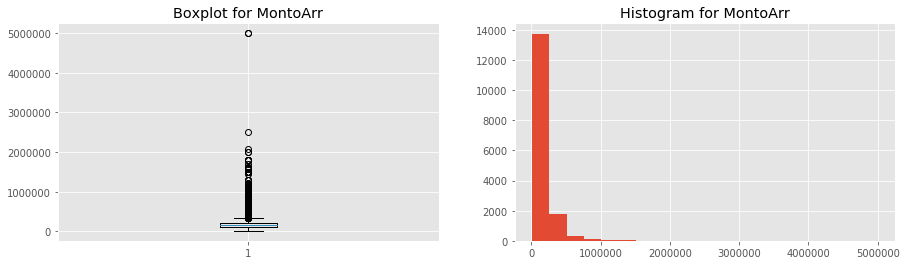

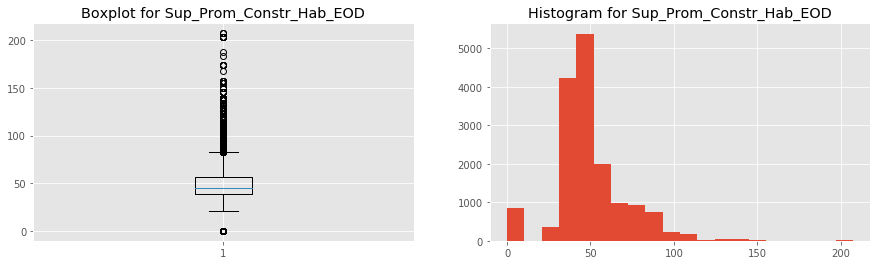

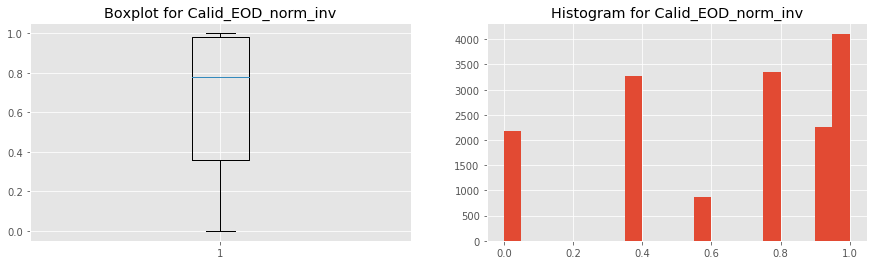

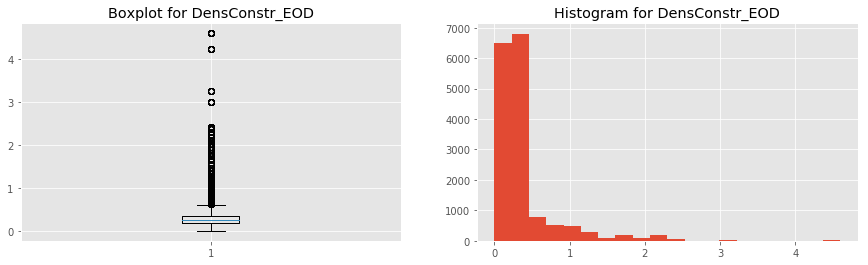

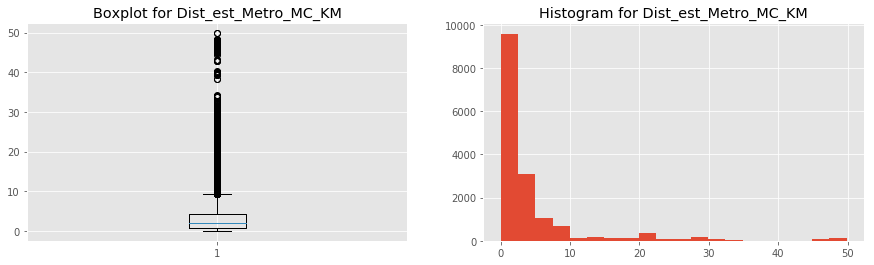

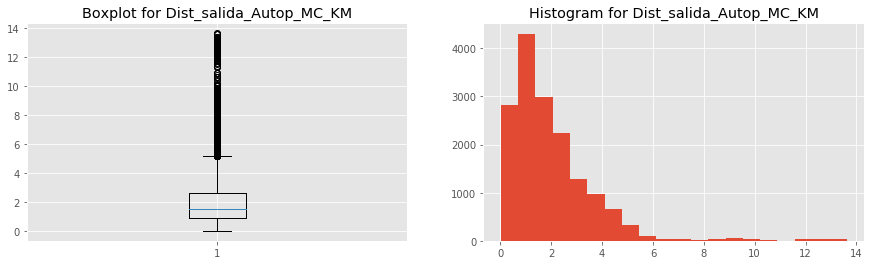

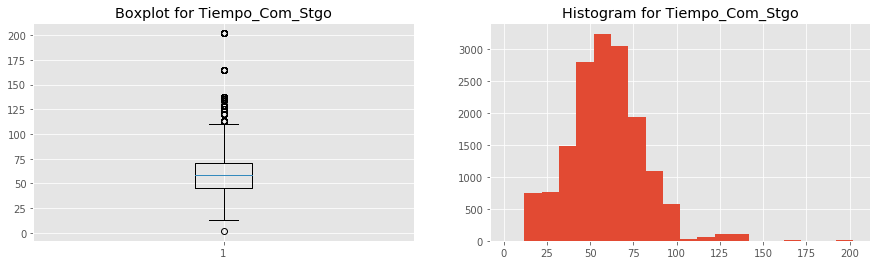

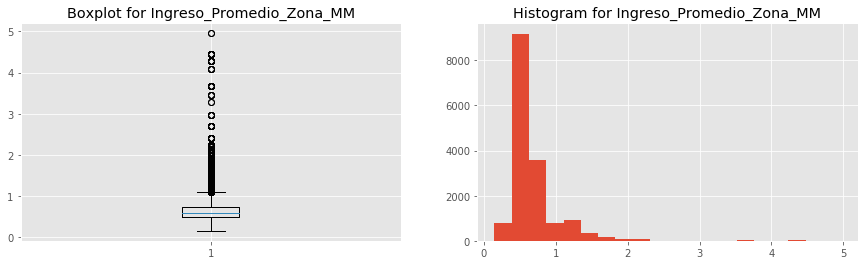

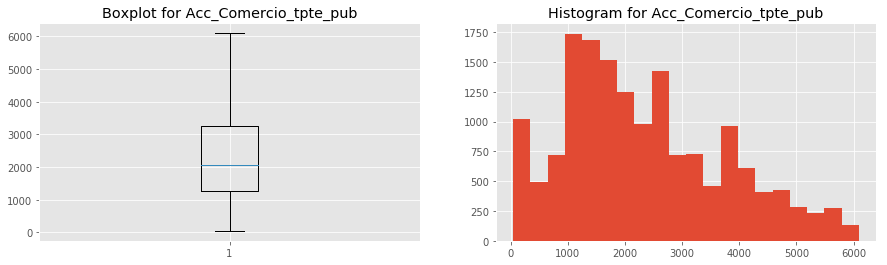

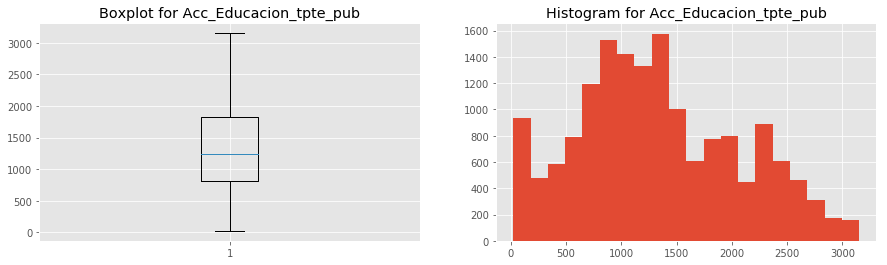

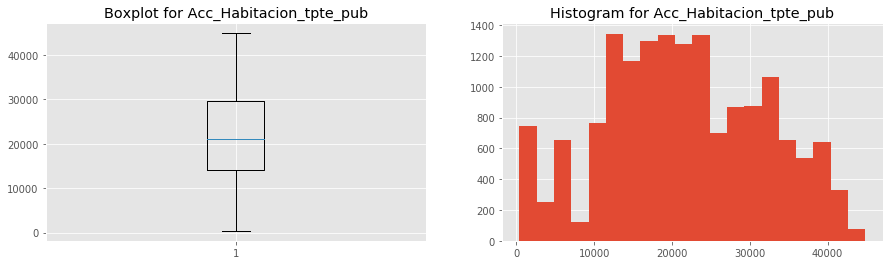

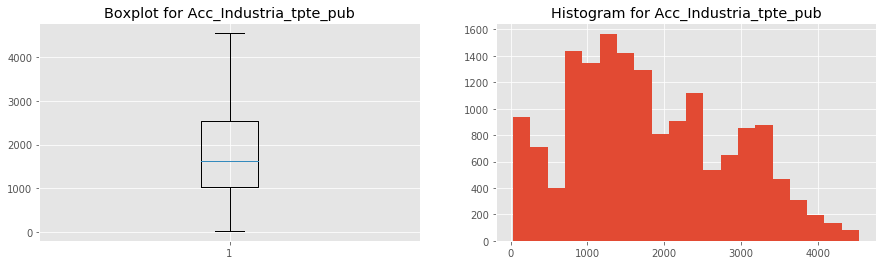

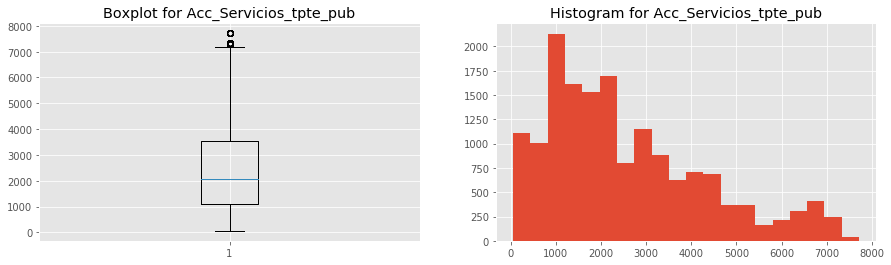

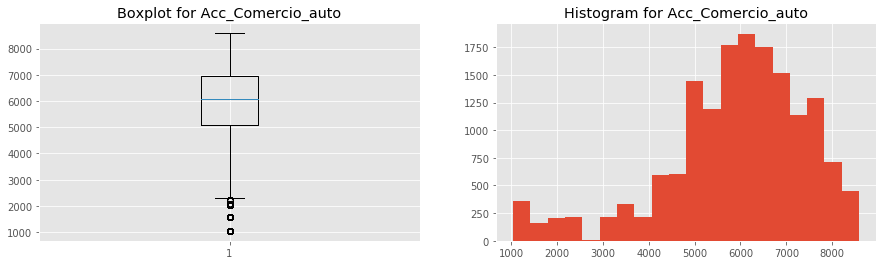

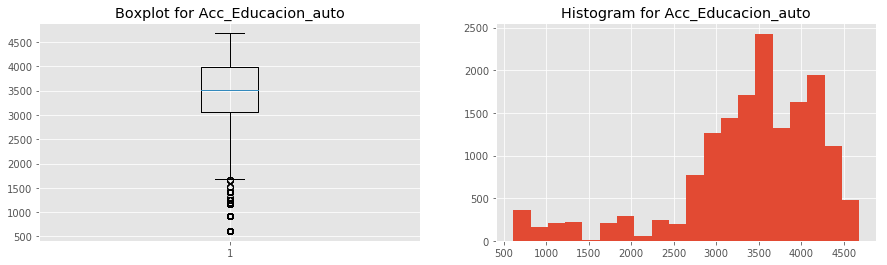

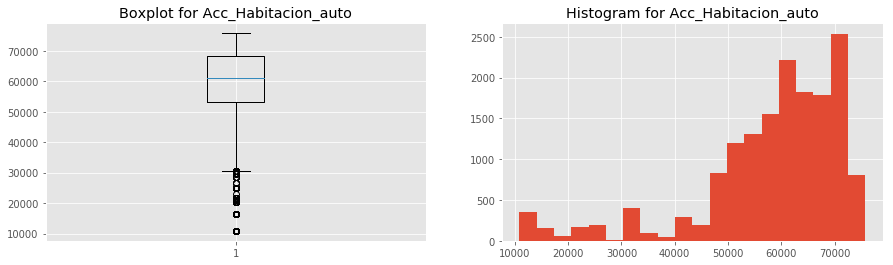

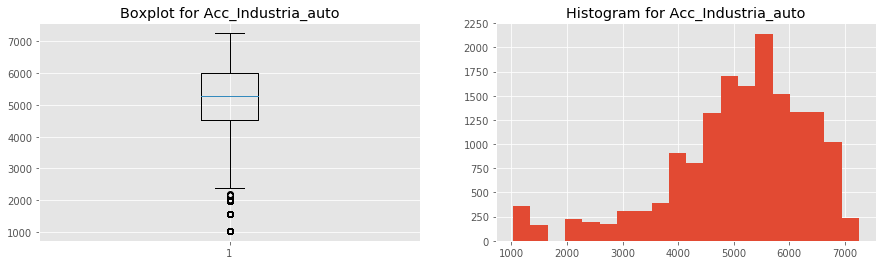

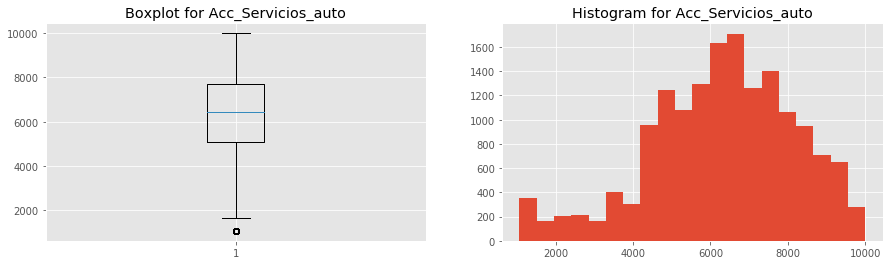

In [7]:
#description.hist(figsize=(30,16));
for feature in description.columns:

    # Initialize the figure
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 4))

    # Extract the feature values
    x = description[feature].to_numpy()

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title('Boxplot for {}'.format(feature))

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title('Histogram for {}'.format(feature))

    # Display
    plt.show()

#### Categorical data

Our categorical variables are:
- Sector: Neighbourhood
- Clase: Type of household
    - 1: less than 12 years; 2: between 12 and 15 years; 3: more than 15 years
- Cluster7 and Cluster2: Clusters given by the creator of the dataset

In [8]:
#seletion of variables
drops = ['MontoArr', 'Sup_Prom_Constr_Hab_EOD',
       'Calid_EOD_norm_inv', 'DensConstr_EOD', 'Dist_est_Metro_MC_KM',
       'Dist_salida_Autop_MC_KM', 'Tiempo_Com_Stgo',
       'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub',
       'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto', 'LONGITUD', 'LATITUD']
data_categorical = data.drop(drops, axis=1) 
data_categorical.head()

Sector  CLASE  CLUSTER7  CLUSTER2
Hogar                                    
100010       7      1         3         1
100020       7      1         3         1
100030       7      1         3         1
100041       7      2         3         1
100052       7      2         3         1

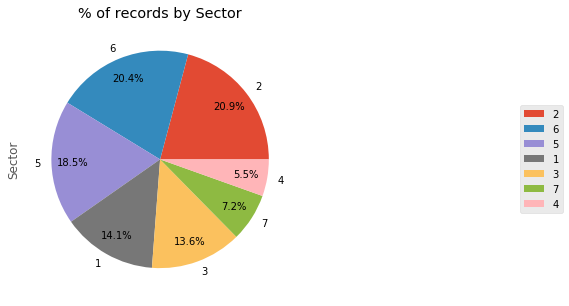

In [9]:
sector = data.Sector.value_counts()
sector.plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8, figsize=(7,5))
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of records by Sector');

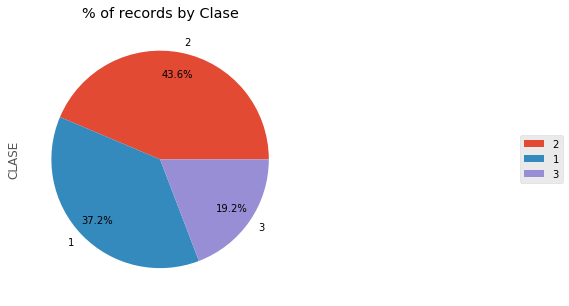

In [10]:
clase = data.CLASE.value_counts()
clase.plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8, figsize=(7,5))
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of records by Clase');

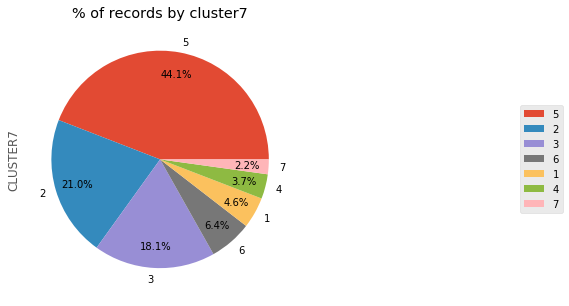

In [11]:
cluster7 = data.CLUSTER7.value_counts()
cluster7.plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8, figsize=(7,5))
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of records by cluster7');

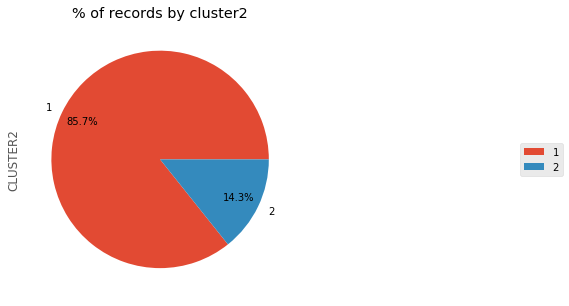

In [12]:
cluster2 = data.CLUSTER2.value_counts()
cluster2.plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8, figsize=(7,5))
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of records by cluster2');

### Preparation data

It is necessary to prepare the categorical variables so the models can read them. For that, we will use one-hot encoding for each categorical variable.

In [13]:
dummies = ['Sector', 'CLUSTER7', 'CLUSTER2']
data_complete = pd.get_dummies(data, columns = dummies)

### Correlation

For understanding how our variables interact between each other, it is useful to look at the correlation matrix.

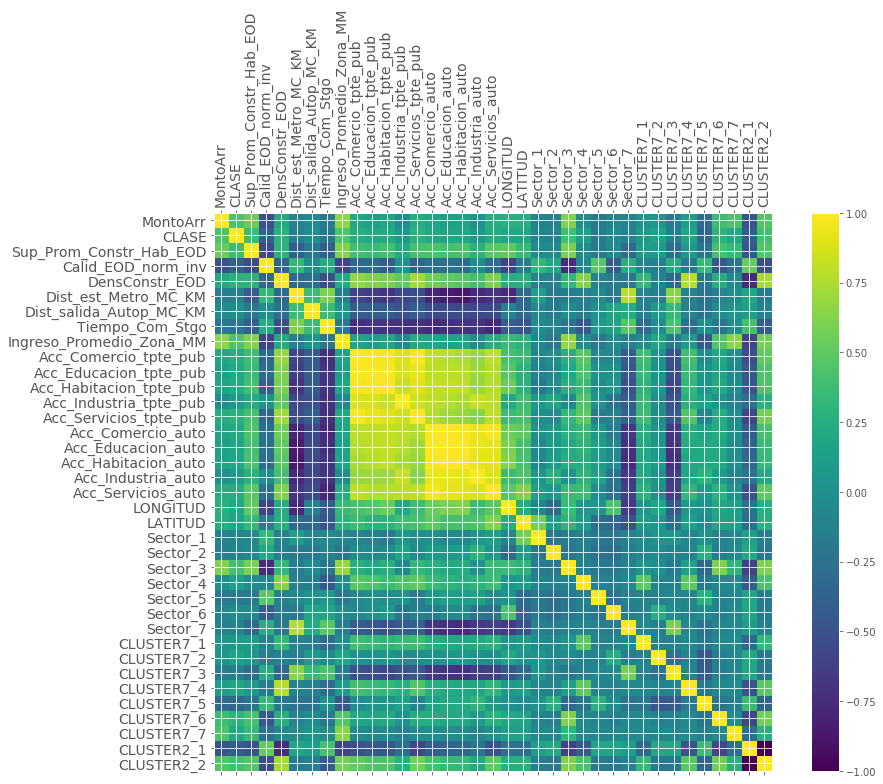

In [14]:
correlations = data_complete.corr()
f = plt.figure(figsize=(14, 10))
plt.matshow(correlations, fignum=f.number)
plt.xticks(range(correlations.shape[1]), correlations.columns, fontsize=14, rotation = 90)
plt.yticks(range(correlations.shape[1]), correlations.columns, fontsize=14)
cb = plt.colorbar();

### Visualization target variable 'CLASE'

Since we have the coordenates of all our data points, it is very useful to plot them in a map to visualize how our target variable is distributed.

!["titulo"](clases.png)
!["titulo"](clase1.png)
!["titulo"](clase2.png)
!["titulo"](clase3.png)

The images have been constructed using PowerBI.

We can observe that the classes are not geographically separable. Indeed, any potential decision boundary that can separate the three classes would have to be quite complex.

### Train and test separation

In [15]:
features_to_use = [ 'MontoArr', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv',
       'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM',
       'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub',
       'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto', 'LONGITUD', 'LATITUD', 'Sector_1', 'Sector_2',
       'Sector_3', 'Sector_5', 'Sector_6', 'Sector_7', 'CLUSTER7_1', 'CLUSTER7_2', 'CLUSTER7_3',
       'CLUSTER7_4', 'CLUSTER7_5', 'CLUSTER7_6', 'CLUSTER7_7', 'CLUSTER2_1',
       'CLUSTER2_2']
target_variable = 'CLASE'

Here it is important to say that why we decided to not to use variable Sector 4.

Sector 4 is inside our test set. When keeping Sector 4, our train set has one column of zeros, shich is not very useful and lead to problems when standardizing so we decided to not to use it. 

In [16]:
X_train = data_complete.loc[ (((data_complete['LONGITUD'] > -70.6) | (data_complete['LONGITUD'] < -70.7)) | ((data_complete['LATITUD'] > -33.4) | (data_complete['LATITUD'] < -33.5))) , features_to_use]
y_train = data_complete.loc[ (((data_complete['LONGITUD'] > -70.6) | (data_complete['LONGITUD'] < -70.7)) | ((data_complete['LATITUD'] > -33.4) | (data_complete['LATITUD'] < -33.5))) , target_variable]
X_test = data_complete.loc[ ((data_complete['LONGITUD'] < -70.6) & (data_complete['LONGITUD'] > -70.7)) & (data_complete['LATITUD'] < -33.4) & (data_complete['LATITUD'] > -33.5) , features_to_use]
y_test = data_complete.loc[ ((data_complete['LONGITUD'] < -70.6) & (data_complete['LONGITUD'] > -70.7)) & (data_complete['LATITUD'] < -33.4) & (data_complete['LATITUD'] > -33.5) , target_variable]

print("Num train examples:", len(y_train))
print("Num test examples:", len(y_test))

Num train examples: 13433
Num test examples: 2614


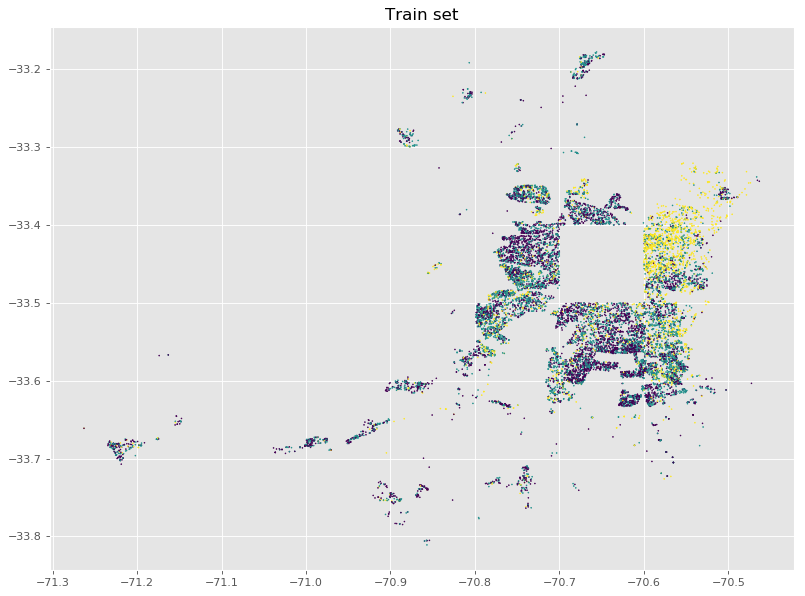

In [17]:
plt.figure(figsize=(12,9), dpi= 80)
plt.scatter(X_train['LONGITUD'], X_train['LATITUD'], s=0.8, c=y_train)
plt.title('Train set', fontsize=15);

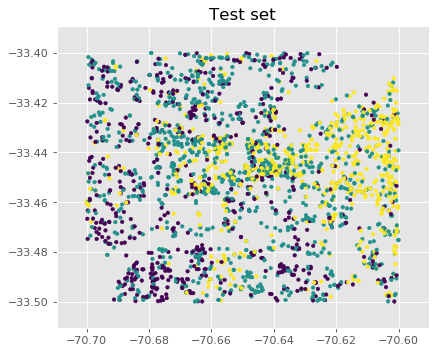

In [18]:
plt.figure(figsize=(6,5), dpi= 80)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=10, c=y_test)
plt.title('Test set', fontsize=15);

### Standarization

In [19]:
# standardize data
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

### Evaluation function

For the following steps in the notebook we will need a fuction that evaluates our models:

In [20]:
# function to evaluate predictions
def evaluate(y_true, y_pred, print_cm=False):
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if print_cm:
        print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
        print(cm)

    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
#    r2 = model.score(X_test, y_test)
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("f1 score:", f1)
 #   print("R^2: {}".format(r2))

## 2. Prediction challenge

The prediction challenge considers the problem of predicting the type of household that will buy the house, given the area characteristics. The type of household is given in the variable “CLASE”.

For this purpose, several models will be presented and adapted to the data, and we will discuss which one is the most appropriated to this case.

### Logistic Regression

The first model to use to predict is logistic regression. It is important to remember that we have three different possible values for variable Clase, so we need to define this psoblem as multiclass.

In [21]:
# estimate model on trainset
lr = LogisticRegression(solver='sag',random_state=42,multi_class='multinomial')
lr.fit(X_train, y_train)

# make predictions
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train_lr)
print("- Test set results:")
evaluate(y_test, y_pred_test_lr)

- Train set results:
accuracy: 0.5863917218789548
precision: 0.544043144304625
recall: 0.5688653451811346
f1 score: 0.5561774287862334
- Test set results:
accuracy: 0.49273144605967867
precision: 0.4690346083788707
recall: 0.44782608695652176
f1 score: 0.45818505338078297


C:\Users\usuario\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The scores are not very good. Let's visualize our predictions compared with the real values:

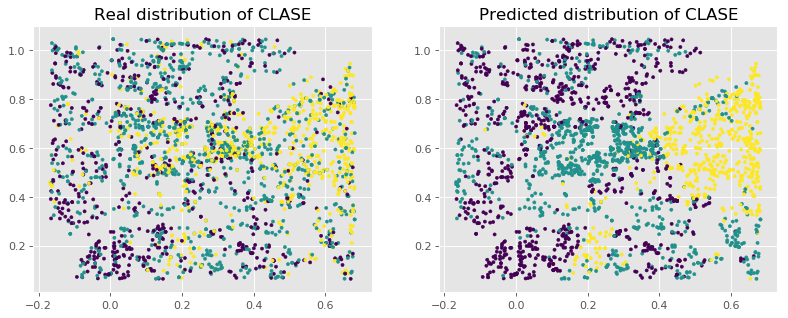

In [22]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_lr);

### SVC

Next model to use is SVC.

In [23]:
sv=SVC()
sv.fit(X_train,y_train)
y_pred_train_sv = sv.predict(X_train)
y_pred_test_sv = sv.predict(X_test)
print("- Train set results:")
evaluate(y_train, y_pred_train_sv)
print("- Test set results:")
evaluate(y_test, y_pred_test_sv)

C:\Users\usuario\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


- Train set results:
accuracy: 0.5929427529219087
precision: 0.559322033898305
recall: 0.5639097744360902
f1 score: 0.5616065350578625
- Test set results:
accuracy: 0.5195103289977047
precision: 0.4977497749774977
recall: 0.4808695652173913
f1 score: 0.4891640866873065


Scores are higher than with Logistic Regression, but still not very good!

Let's see the distribution.

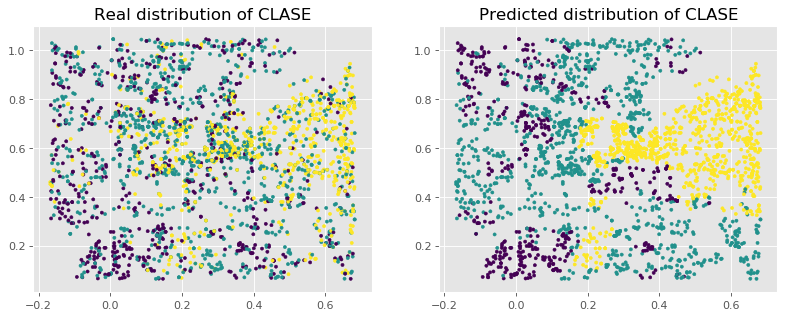

In [24]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_sv);

### Decision Trees

In [25]:
tree=DecisionTreeClassifier()
tree.fit(X_train,y_train)
y_pred_train_tree = tree.predict(X_train)
y_pred_test_tree = tree.predict(X_test)
print("- Train set results:")
evaluate(y_train, y_pred_train_tree)
print("- Test set results:")
evaluate(y_test, y_pred_test_tree)

- Train set results:
accuracy: 0.9959056055981538
precision: 0.9974266598044261
recall: 0.9935064935064936
f1 score: 0.9954627172331137
- Test set results:
accuracy: 0.4085692425401683
precision: 0.449438202247191
recall: 0.41739130434782606
f1 score: 0.4328223624887286


Here we can see that for the trained set scores are very high, but we don't have the same results in our test set. This is due to overfitting. We need to modify the model to fix this.

In [26]:
tree=DecisionTreeClassifier(max_depth=3, min_samples_leaf=1) #modifications to avoid overfitting
tree.fit(X_train,y_train)
y_pred_train_tree = tree.predict(X_train)
y_pred_test_tree = tree.predict(X_test)
print("- Train set results:")
evaluate(y_train, y_pred_train_tree)
print("- Test set results:")
evaluate(y_test, y_pred_test_tree)

- Train set results:
accuracy: 0.5707585796173602
precision: 0.5135576198845092
recall: 0.6990772385509227
f1 score: 0.5921262121870025
- Test set results:
accuracy: 0.5145371078806427
precision: 0.47564935064935066
recall: 0.7643478260869565
f1 score: 0.5863909272848566


Much better. And scores keep getting hisgher than the previous models.

Visualizations:

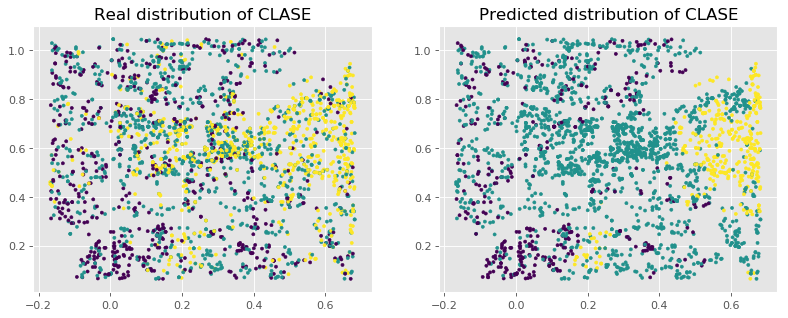

In [27]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_tree);

In [28]:
rf=RandomForestClassifier(max_depth=3, min_samples_leaf=4)
rf.fit(X_train, y_train)
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)
print("- Train set results:")
evaluate(y_train, y_pred_train_rf)
print("- Test set results:")
evaluate(y_test, y_pred_test_rf)

C:\Users\usuario\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


- Train set results:
accuracy: 0.5704608054790441
precision: 0.5288903479973736
recall: 0.550580997949419
f1 score: 0.5395177494976557
- Test set results:
accuracy: 0.5386381025248661
precision: 0.49636363636363634
recall: 0.7121739130434782
f1 score: 0.585


Random forest don't give us better results than classification trees.

### Neural Networks

Now, let's try with neural networks. For this, we will change our train set in order to get data for validation. Our validation set will be the square around the test set as can be seen in the following visualization. 

In [29]:
X_train_nn = data_complete.loc[ (((data_complete['LONGITUD'] > -70.58) | (data_complete['LONGITUD'] < -70.72)) | ((data_complete['LATITUD'] > -33.38) | (data_complete['LATITUD'] < -33.52))) , features_to_use]
y_train_nn = data_complete.loc[ (((data_complete['LONGITUD'] > -70.58) | (data_complete['LONGITUD'] < -70.72)) | ((data_complete['LATITUD'] > -33.38) | (data_complete['LATITUD'] < -33.52))) , target_variable]

X_val_nn = data_complete.loc[ (((data_complete['LONGITUD'] > -70.6) | (data_complete['LONGITUD'] < -70.7)) |
                               (data_complete['LATITUD'] > -33.4) | (data_complete['LATITUD'] < -33.5)) &
                             (((data_complete['LONGITUD'] < -70.58) & (data_complete['LONGITUD'] > -70.72)) & 
                              ((data_complete['LATITUD'] < -33.38) & (data_complete['LATITUD'] > -33.52))), features_to_use]

y_val_nn = data_complete.loc[ (((data_complete['LONGITUD'] > -70.6) | (data_complete['LONGITUD'] < -70.7)) |
                               (data_complete['LATITUD'] > -33.4) | (data_complete['LATITUD'] < -33.5)) &
                             (((data_complete['LONGITUD'] < -70.58) & (data_complete['LONGITUD'] > -70.72)) & 
                              ((data_complete['LATITUD'] < -33.38) & (data_complete['LATITUD'] > -33.52))), target_variable]

X_test_nn = data_complete.loc[ ((data_complete['LONGITUD'] < -70.6) & (data_complete['LONGITUD'] > -70.7)) & (data_complete['LATITUD'] < -33.4) & (data_complete['LATITUD'] > -33.5) , features_to_use]
y_test_nn = data_complete.loc[ ((data_complete['LONGITUD'] < -70.6) & (data_complete['LONGITUD'] > -70.7)) & (data_complete['LATITUD'] < -33.4) & (data_complete['LATITUD'] > -33.5) , target_variable]

print("Num train examples:", len(y_train_nn))
print("Num validation examples:", len(y_val_nn))
print("Num test examples:", len(y_test_nn))

Num train examples: 11223
Num validation examples: 2210
Num test examples: 2614


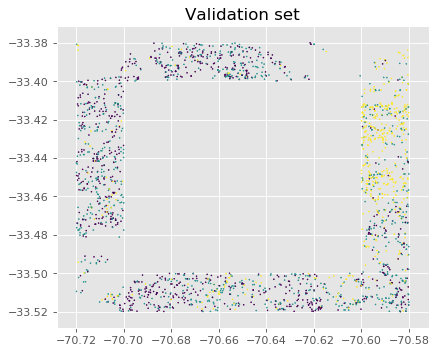

In [30]:
plt.figure(figsize=(6,5), dpi= 80)
plt.scatter(X_val_nn['LONGITUD'], X_val_nn['LATITUD'], s=0.8, c=y_val_nn)
plt.title('Validation set', fontsize=15);

In [31]:
# standardize data
X_mean = X_train_nn.mean(axis=0)
X_std = X_train_nn.std(axis=0)
X_train_nn = (X_train_nn - X_mean) / X_std
X_val_nn = (X_val_nn - X_mean) / X_std
X_test_nn = (X_test_nn - X_mean) / X_std

Since we are using categorical crossentropy function we need to chnge the format of our target variable to one-hot encoding.

In [32]:
y_train_dummies = pd.get_dummies(y_train_nn, columns = 'CLASE')
y_val_dummies = pd.get_dummies(y_val_nn, columns = 'CLASE')
y_test_dummies = pd.get_dummies(y_test_nn, columns = 'CLASE')

In [47]:
# define the keras model
nn = Sequential()
nn.add(Dense(100,activation='relu',input_shape=(35,)))
nn.add(Dropout(0.2))
nn.add(Dense(78,activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(3,activation='softmax'))

# compile the keras model
nn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# fit the keras model on the dataset
nn.fit(X_train_nn, y_train_dummies, epochs=5, batch_size=128, validation_data=(X_val_nn,y_val_dummies))

# evaluate the keras model
y_pred_val_nn = nn.predict(X_val_nn)
y_pred_test_nn = nn.predict(X_test_nn)

max_num_val = y_pred_val_nn.max(axis=1)
max_nums_val = np.matrix([max_num_val, max_num_val, max_num_val]).transpose()
y_pred_val_nn = (y_pred_val_nn >= max_nums_val).astype(int)

max_num_test = y_pred_test_nn.max(axis=1)
max_nums_test = np.matrix([max_num_test, max_num_test, max_num_test]).transpose()
y_pred_test_nn = (y_pred_test_nn >= max_nums_test).astype(int)

y_pred_val_nn_df = pd.DataFrame(y_pred_val_nn, columns=['1', '2', '3'])
y_pred_test_nn_df = pd.DataFrame(y_pred_test_nn, columns=['1', '2', '3'])
y_pred_val_nn_ = y_pred_val_nn_df.idxmax(axis=1)
y_pred_test_nn_ = y_pred_test_nn_df.idxmax(axis=1)

## evaluate predictions
print("- Validation set results:")
evaluate(y_val_nn.astype(str), y_pred_val_nn_.astype(str))
print("- Test set results:")
evaluate(y_test_nn.astype(str), y_pred_test_nn_.astype(str))

Train on 11223 samples, validate on 2210 samples
Epoch 1/5
11223/11223 [==============================] - 0s 36us/step - loss: 0.9245 - accuracy: 0.5162 - val_loss: 0.8995 - val_accuracy: 0.5308
Epoch 2/5
11223/11223 [==============================] - 0s 24us/step - loss: 0.8776 - accuracy: 0.5482 - val_loss: 0.9078 - val_accuracy: 0.5665
Epoch 3/5
11223/11223 [==============================] - 0s 24us/step - loss: 0.8601 - accuracy: 0.5638 - val_loss: 0.8887 - val_accuracy: 0.5733
Epoch 4/5
11223/11223 [==============================] - 0s 25us/step - loss: 0.8542 - accuracy: 0.5701 - val_loss: 0.9167 - val_accuracy: 0.5656
Epoch 5/5
11223/11223 [==============================] - 0s 25us/step - loss: 0.8467 - accuracy: 0.5837 - val_loss: 0.8963 - val_accuracy: 0.5620
- Validation set results:
accuracy: 0.5619909502262443
precision: 0.48496605237633367
recall: 0.5549389567147613
f1 score: 0.5175983436853002
- Test set results:
accuracy: 0.5256312165263963
precision: 0.4968152866242038


Not the best predictions until now.

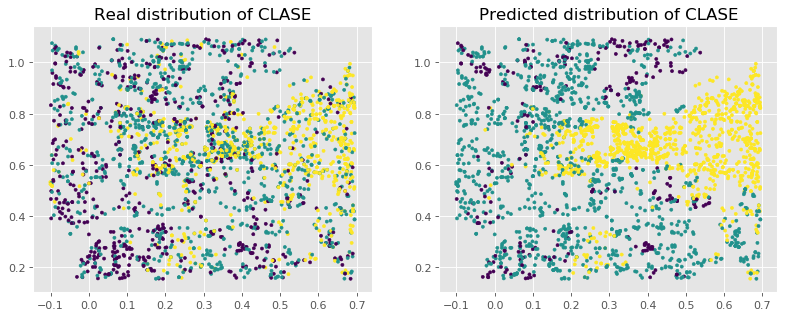

In [48]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test_nn['LONGITUD'], X_test_nn['LATITUD'], s=8, c=y_test_nn)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test_nn['LONGITUD'], X_test_nn['LATITUD'], s=8, c=y_pred_test_nn_.astype(int));

Modifications to our keras model:

In [109]:
# define the keras model
nnm = Sequential()
nnm.add(Dense(100,activation='relu',input_shape=(35,)))
nnm.add(Dropout(0.5))
nnm.add(Dense(70,activation='relu'))
nnm.add(Dropout(0.5))
nnm.add(Dense(40,activation='relu'))
nnm.add(Dropout(0.5))
nnm.add(Dense(3,activation='softmax'))

# compile the keras model
nnm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# fit the keras model on the dataset
nnm.fit(X_train_nn, y_train_dummies, epochs=50, batch_size=1024, validation_data=(X_val_nn,y_val_dummies))

# evaluate the keras model
y_pred_val_nnm = nnm.predict(X_val_nn)
y_pred_test_nnm = nnm.predict(X_test_nn)

max_num_val = y_pred_val_nnm.max(axis=1)
max_nums_val = np.matrix([max_num_val, max_num_val, max_num_val]).transpose()
y_pred_val_nnm = (y_pred_val_nnm >= max_nums_val).astype(int)

max_num_test = y_pred_test_nnm.max(axis=1)
max_nums_test = np.matrix([max_num_test, max_num_test, max_num_test]).transpose()
y_pred_test_nnm = (y_pred_test_nnm >= max_nums_test).astype(int)

y_pred_val_nnm_df = pd.DataFrame(y_pred_val_nnm, columns=['1', '2', '3'])
y_pred_test_nnm_df = pd.DataFrame(y_pred_test_nnm, columns=['1', '2', '3'])
y_pred_val_nnm_ = y_pred_val_nnm_df.idxmax(axis=1)
y_pred_test_nnm_ = y_pred_test_nnm_df.idxmax(axis=1)

## evaluate predictions
print("- Train set results:")
evaluate(y_val_nn.astype(str), y_pred_val_nnm_.astype(str))
print("- Test set results:")
evaluate(y_test_nn.astype(str), y_pred_test_nnm_.astype(str))

Train on 11223 samples, validate on 2210 samples
Epoch 1/50
11223/11223 [==============================] - 1s 61us/step - loss: 1.1615 - accuracy: 0.3785 - val_loss: 1.0332 - val_accuracy: 0.5014
Epoch 2/50
11223/11223 [==============================] - 0s 10us/step - loss: 1.0406 - accuracy: 0.4431 - val_loss: 0.9805 - val_accuracy: 0.5330
Epoch 3/50
11223/11223 [==============================] - 0s 11us/step - loss: 1.0110 - accuracy: 0.4578 - val_loss: 0.9361 - val_accuracy: 0.5285
Epoch 4/50
11223/11223 [==============================] - 0s 11us/step - loss: 0.9798 - accuracy: 0.4743 - val_loss: 0.9078 - val_accuracy: 0.5213
Epoch 5/50
11223/11223 [==============================] - 0s 11us/step - loss: 0.9681 - accuracy: 0.4745 - val_loss: 0.8837 - val_accuracy: 0.5425
Epoch 6/50
11223/11223 [==============================] - 0s 11us/step - loss: 0.9522 - accuracy: 0.4940 - val_loss: 0.8696 - val_accuracy: 0.5425
Epoch 7/50
11223/11223 [==============================] - 0s 11us/ste

After modifying the neural network model we get better results, but they are not very satisfactory indeed.

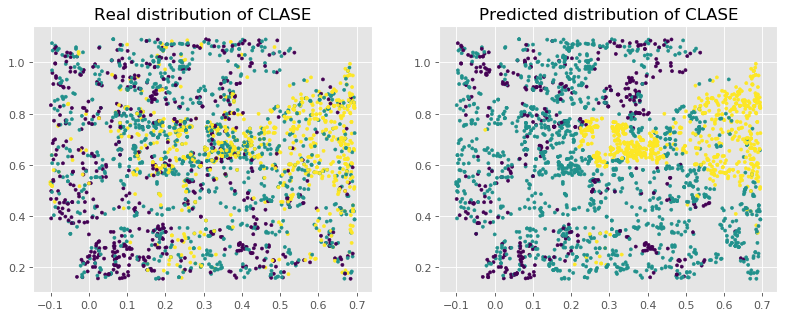

In [110]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test_nn['LONGITUD'], X_test_nn['LATITUD'], s=8, c=y_test_nn)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test_nn['LONGITUD'], X_test_nn['LATITUD'], s=8, c=y_pred_test_nnm_.astype(int));

What can be seen with all the visualizations is that what the models are predicting is three geographical separate classes, but the real geographical distribution is not that strong. Actually, in our test set the three classes are very mixed between them, so the models need to look for other variables that link the classes.

We now will apply some of the possible modifications to the performance learned in class that can improve the results.

### Shuffle

Shuffling is not actually something that we can use since our test set is fixed to a region.

### Over/underfitting

Let's compare with our logistic regression model. Previous results:

In [33]:
print("- Train set results:")
evaluate(y_train, y_pred_train_lr)
print("- Test set results:")
evaluate(y_test, y_pred_test_lr)

- Train set results:
accuracy: 0.5863917218789548
precision: 0.544043144304625
recall: 0.5688653451811346
f1 score: 0.5561774287862334
- Test set results:
accuracy: 0.49273144605967867
precision: 0.4690346083788707
recall: 0.44782608695652176
f1 score: 0.45818505338078297


In [34]:
# estimate model on trainset
lrc = LogisticRegression(C=0.01, solver='sag',random_state=42,multi_class='multinomial')
lrc.fit(X_train, y_train)

# make predictions
y_pred_train_lrc = lrc.predict(X_train)
y_pred_test_lrc = lrc.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train_lrc)
print("- Test set results:")
evaluate(y_test, y_pred_test_lrc)

- Train set results:
accuracy: 0.5774584977294722
precision: 0.5367118247198528
recall: 0.5483595352016405
f1 score: 0.5424731637224242
- Test set results:
accuracy: 0.5030604437643458
precision: 0.47280334728033474
recall: 0.49130434782608695
f1 score: 0.48187633262260127


Best results we got are setting C=0.01, but the improvements are not very important.

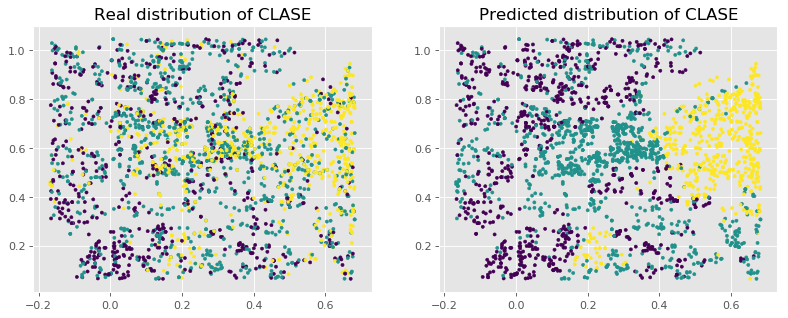

In [35]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_lrc);

### L1 and L2 regularization

#### Regularization in Logistic regression

In [36]:
# estimate model on trainset
lrl1 = LogisticRegression(penalty='l1', C=0.01, solver='saga',random_state=42,multi_class='multinomial')
lrl1.fit(X_train, y_train)

# make predictions
y_pred_train_lrl1 = lrl1.predict(X_train)
y_pred_test_lrl1 = lrl1.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train_lrl1)
print("- Test set results:")
evaluate(y_test, y_pred_test_lrl1)

- Train set results:
accuracy: 0.5691952653912008
precision: 0.5277104260478005
recall: 0.5206766917293233
f1 score: 0.5241699638740753
- Test set results:
accuracy: 0.5042081101759756
precision: 0.47309573724668064
recall: 0.5886956521739131
f1 score: 0.524602867105773


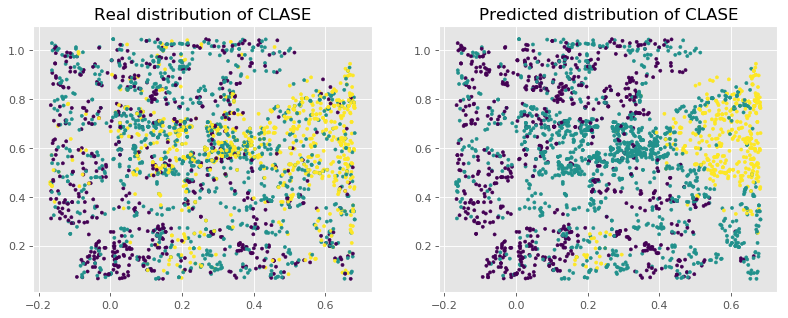

In [37]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_lrl1);

Results have improved compared with logistic regression without regularization. What is interesting to see here is which are the variables that the model is considering that are or not relevant.

In [38]:
suma = 0
for i in range(len(features_to_use)):
    if lrl1.coef_[0][i] == 0:
        #print("Feature %s is irrelevant" % (features_to_use[i],))
        suma = suma + 1
print('Total irrelevant features: ', suma)

Total irrelevant features:  28


In [39]:
suma = 0
best_features = []
j = 0
for i in range(len(features_to_use)):
    if lrl1.coef_[0][i] != 0:
        print("Feature %s is relevant" % (features_to_use[i],))
        suma = suma + 1
        best_features.append(features_to_use[i])
        j = j+1
print('Total relevant features: ', suma)
print(best_features)

Feature MontoArr is relevant
Feature Ingreso_Promedio_Zona_MM is relevant
Feature Sector_2 is relevant
Feature Sector_5 is relevant
Feature Sector_6 is relevant
Feature CLUSTER7_2 is relevant
Feature CLUSTER7_5 is relevant
Total relevant features:  7
['MontoArr', 'Ingreso_Promedio_Zona_MM', 'Sector_2', 'Sector_5', 'Sector_6', 'CLUSTER7_2', 'CLUSTER7_5']


We can see that current clusters doesn't give us a lot of information, we will explore new clusters and a reduced dataset with the relevant features further in this notebook.

#### Regularization in neural networks

In [57]:
# define the keras model
nnr = Sequential()
nnr.add(Dense(100,activation='relu',input_shape=(35,), kernel_regularizer=regularizers.l2(0.001)))
nnr.add(Dense(70,activation='relu', kernel_regularizer=regularizers.l2(0.1)))
nnr.add(Dense(40,activation='relu', kernel_regularizer=regularizers.l2(0.11)))
nnr.add(Dense(3,activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

# compile the keras model
nnr.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# fit the keras model on the dataset
history = nnr.fit(X_train_nn, y_train_dummies, epochs=50, batch_size=1024, validation_data=(X_val_nn,y_val_dummies))

# evaluate the keras model
y_pred_val_nnr = nnr.predict(X_val_nn)
y_pred_test_nnr = nnr.predict(X_test_nn)

max_num_val = y_pred_val_nnr.max(axis=1)
max_nums_val = np.matrix([max_num_val, max_num_val, max_num_val]).transpose()
y_pred_val_nnr = (y_pred_val_nnr >= max_nums_val).astype(int)

max_num_test = y_pred_test_nnr.max(axis=1)
max_nums_test = np.matrix([max_num_test, max_num_test, max_num_test]).transpose()
y_pred_test_nnr = (y_pred_test_nnr >= max_nums_test).astype(int)

y_pred_val_nnr_df = pd.DataFrame(y_pred_val_nnr, columns=['1', '2', '3'])
y_pred_test_nnr_df = pd.DataFrame(y_pred_test_nnr, columns=['1', '2', '3'])
y_pred_val_nnr_ = y_pred_val_nnr_df.idxmax(axis=1)
y_pred_test_nnr_ = y_pred_test_nnr_df.idxmax(axis=1)

## evaluate predictions
print("- Train set results:")
evaluate(y_val_nn.astype(str), y_pred_val_nnr_.astype(str))
print("- Test set results:")
evaluate(y_test_nn.astype(str), y_pred_test_nnr_.astype(str))

Train on 11223 samples, validate on 2210 samples
Epoch 1/50
11223/11223 [==============================] - 0s 19us/step - loss: 13.1697 - accuracy: 0.4621 - val_loss: 11.6121 - val_accuracy: 0.4986
Epoch 2/50
11223/11223 [==============================] - 0s 7us/step - loss: 10.7544 - accuracy: 0.5172 - val_loss: 9.7504 - val_accuracy: 0.5009
Epoch 3/50
11223/11223 [==============================] - 0s 7us/step - loss: 9.0832 - accuracy: 0.5233 - val_loss: 8.2519 - val_accuracy: 0.5176
Epoch 4/50
11223/11223 [==============================] - 0s 7us/step - loss: 7.6890 - accuracy: 0.5323 - val_loss: 6.9725 - val_accuracy: 0.5330
Epoch 5/50
11223/11223 [==============================] - 0s 7us/step - loss: 6.4885 - accuracy: 0.5376 - val_loss: 5.8651 - val_accuracy: 0.5348
Epoch 6/50
11223/11223 [==============================] - 0s 7us/step - loss: 5.4503 - accuracy: 0.5400 - val_loss: 4.9103 - val_accuracy: 0.5344
Epoch 7/50
11223/11223 [==============================] - 0s 6us/step -

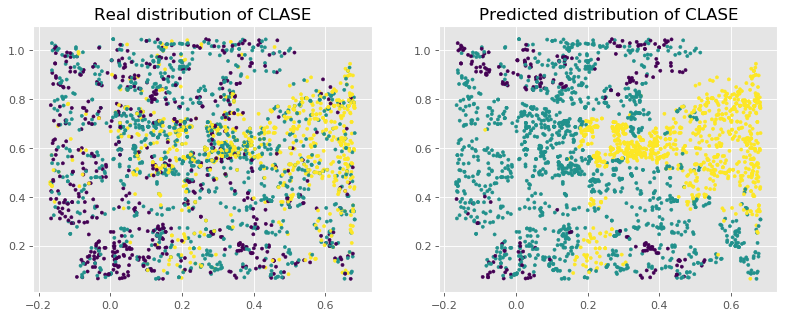

In [58]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_nnr_.astype(int));

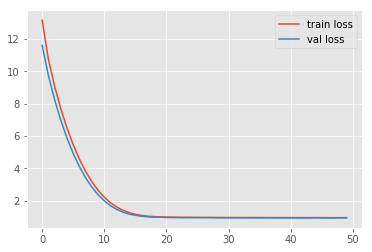

In [59]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train loss", "val loss"])
plt.show()

## 3. Exploratory component

The exploratory component of the project will consist of study how the variables of the dataset affect the predictions. For this pourpose three different approaches will be considered:
- Adding a new cluster
- Predicting with the relevant features that have been determined with l1 regularization
- Try dimensionality reduction

### 3.1 New Cluster k = 4

Since the clusters already given in the dataset weren't very informative for the prediction of variables 'CLASE' we will apply KMeans clustering with k=4 and check if this cluster might be more useful than the others.

In [60]:
#We won't use dummy variables for the prediction of the clusters, they are not very informative when using KMeans
features_no_clusters = [ 'MontoArr', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv',
       'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM',
       'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub',
       'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto']

In [61]:
data_no_clusters = data_complete[features_no_clusters]
lon = data_complete['LONGITUD']
lat = data_complete['LATITUD']

In [62]:
#normalize the data for variables to be comparable
norm = Normalizer()
X = norm.fit_transform(data_no_clusters)

In [63]:
K=4
k=KMeans(K)
k.fit(X);

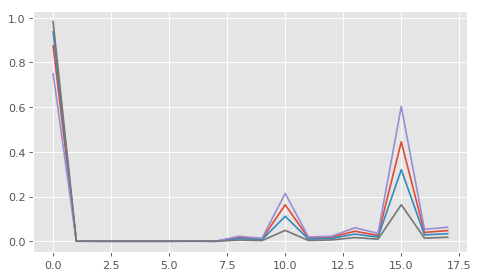

In [64]:
plt.figure(figsize=(7,4), dpi= 80)
x=range(18)
for c in k.cluster_centers_:
    plt.plot(x, c)

Few variables are used to determine the clusters, and values don't vary a lot.

In [65]:
clusters = k.fit_predict(data_no_clusters)

In [66]:
data_no_clusters['LONGITUD'] = lon
data_no_clusters['LATITUD'] = lat

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


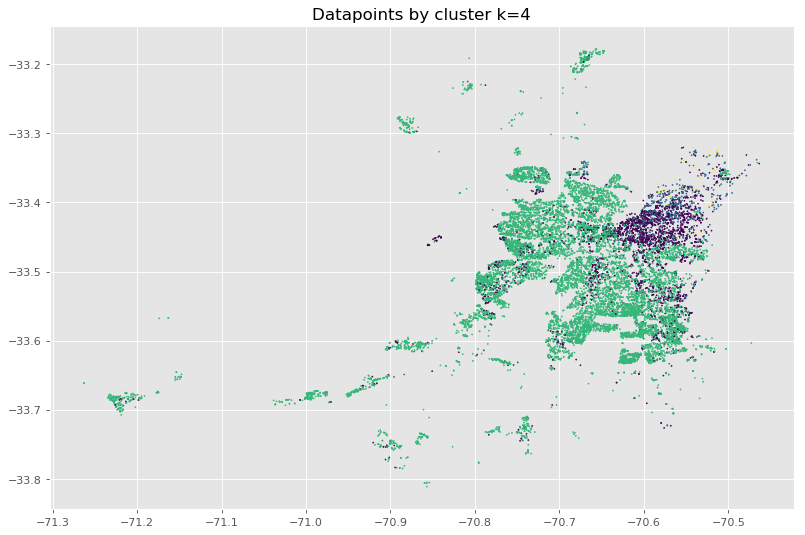

In [67]:
#Visualization of the clusters in the map
plt.figure(figsize=(12,8), dpi= 80)
plt.scatter(data_no_clusters['LONGITUD'], data_no_clusters['LATITUD'], s=1, c=clusters)
plt.title('Datapoints by cluster k=4', fontsize=15);
#plt.scatter(k.cluster_centers_[:, 18], k.cluster_centers_[:, 19], s=200, c=['olive', 'coral', 'teal', 'yellow']);

With this distribution it seems that this clusters won't be very informative nor improve the performance of the models.

In [82]:
data_clusters=data_complete.copy()

In [83]:
data_clusters['cluster4']= clusters
#clase = data_complete['CLASE']
#data_clusters['CLASE'] = clase

In [84]:
data_clusters = pd.get_dummies(data_clusters,  columns= ['cluster4'] )

In [85]:
features_to_use_clusters = [ 'MontoArr', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv',
       'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM',
       'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub',
       'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto', 'LONGITUD', 'LATITUD', 'Sector_1', 'Sector_2',
       'Sector_3', 'Sector_5', 'Sector_6', 'Sector_7', 'cluster4_0',
       'cluster4_1', 'cluster4_2', 'cluster4_3']
target_variable = 'CLASE'

In [86]:
X_train_cluster = data_clusters.loc[ (((data_clusters['LONGITUD'] > -70.6) | (data_clusters['LONGITUD'] < -70.7)) | ((data_clusters['LATITUD'] > -33.4) | (data_clusters['LATITUD'] < -33.5))) , features_to_use_clusters]
y_train_cluster = data_clusters.loc[ (((data_clusters['LONGITUD'] > -70.6) | (data_clusters['LONGITUD'] < -70.7)) | ((data_clusters['LATITUD'] > -33.4) | (data_clusters['LATITUD'] < -33.5))) , target_variable]
X_test_cluster = data_clusters.loc[ ((data_clusters['LONGITUD'] < -70.6) & (data_clusters['LONGITUD'] > -70.7)) & (data_clusters['LATITUD'] < -33.4) & (data_clusters['LATITUD'] > -33.5) , features_to_use_clusters]
y_test_cluster = data_clusters.loc[ ((data_clusters['LONGITUD'] < -70.6) & (data_clusters['LONGITUD'] > -70.7)) & (data_clusters['LATITUD'] < -33.4) & (data_clusters['LATITUD'] > -33.5) , target_variable]

print("Num train examples:", len(y_train_cluster))
print("Num test examples:", len(y_test_cluster))

Num train examples: 13433
Num test examples: 2614


In [87]:
# standardize data
X_mean = X_train_cluster.mean(axis=0)
X_std = X_train_cluster.std(axis=0)
X_train_cluster = (X_train_cluster - X_mean) / X_std
X_test_cluster = (X_test_cluster - X_mean) / X_std

#### Is this cluster informative?

In [79]:
print("- Train set results:")
evaluate(y_train, y_pred_train_lrl1)
print("- Test set results:")
evaluate(y_test, y_pred_test_lrl1)

- Train set results:
accuracy: 0.5691952653912008
precision: 0.5277104260478005
recall: 0.5206766917293233
f1 score: 0.5241699638740753
- Test set results:
accuracy: 0.5042081101759756
precision: 0.47309573724668064
recall: 0.5886956521739131
f1 score: 0.524602867105773


In [89]:
# estimate model on trainset
lrl1_cluster = LogisticRegression(penalty='l1', C=0.01, solver='saga',random_state=42,multi_class='multinomial')
lrl1_cluster.fit(X_train_cluster, y_train_cluster)

# make predictions
y_pred_train_lrl1_cluster = lrl1_cluster.predict(X_train_cluster)
y_pred_test_lrl1_cluster = lrl1_cluster.predict(X_test_cluster)

print("- Train set results:")
evaluate(y_train_cluster, y_pred_train_lrl1_cluster)
print("- Test set results:")
evaluate(y_test_cluster, y_pred_test_lrl1_cluster)

- Train set results:
accuracy: 0.5721730067743617
precision: 0.5293143424975157
recall: 0.5461380724538619
f1 score: 0.5375946173254836
- Test set results:
accuracy: 0.5022953328232593
precision: 0.46902017291066284
recall: 0.5660869565217391
f1 score: 0.5130023640661939


The performance of the model improves when trying to adapt to the train set, so this cluster is more explanatory than previous ones. But when trying to predict on the test set the performance is worse, this may be due to the problem we have been facing before of the geographical distribution of the classes in the train set and the mix of it in the test set.

### 3.2 Data with only relevant features

Sometimes, too many variables can affect on a negative way to the predictions. They can lead to the model to misunderstand some of the data, when using a lot of dummy variables or by creating false relationships between features. This is why we will measure the performance of predictions of our models but only with the relevant features determined by l regularization, so the other ones do not interfere with them.

In [67]:
#features to use
print(best_features)

['MontoArr', 'Ingreso_Promedio_Zona_MM', 'Sector_2', 'Sector_5', 'Sector_6', 'CLUSTER7_2', 'CLUSTER7_5']


Add lon y lat to be able to get train and test sets and visualize the data.

In [90]:
best_features.append('LONGITUD')
best_features.append('LATITUD')

In [91]:
print(best_features)

['MontoArr', 'Ingreso_Promedio_Zona_MM', 'Sector_2', 'Sector_5', 'Sector_6', 'CLUSTER7_2', 'CLUSTER7_5', 'LONGITUD', 'LATITUD']


In [92]:
small_data = data_complete[best_features]

In [93]:
X_train_small = small_data.loc[ (((small_data['LONGITUD'] > -70.6) | (small_data['LONGITUD'] < -70.7)) | ((small_data['LATITUD'] > -33.4) | (small_data['LATITUD'] < -33.5))) ]
#y_train = small_data.loc[ (((small_data['LONGITUD'] > -70.6) | (small_data['LONGITUD'] < -70.7)) | ((small_data['LATITUD'] > -33.4) | (small_data['LATITUD'] < -33.5))) , target_variable]
X_test_small = small_data.loc[ ((small_data['LONGITUD'] < -70.6) & (small_data['LONGITUD'] > -70.7)) & (small_data['LATITUD'] < -33.4) & (small_data['LATITUD'] > -33.5)]
#y_test = small_data.loc[ ((small_data['LONGITUD'] < -70.6) & (small_data['LONGITUD'] > -70.7)) & (small_data['LATITUD'] < -33.4) & (small_data['LATITUD'] > -33.5) , target_variable]

print("Num train examples:", len(y_train))
print("Num test examples:", len(y_test))

Num train examples: 13433
Num test examples: 2614


Target variable and its values are the same as before, we are just reducing the number of variables in X

In [94]:
X_train_small = X_train_small.drop(['LONGITUD', 'LATITUD'], axis = 1)
X_test_small = X_test_small.drop(['LONGITUD', 'LATITUD'], axis = 1)

In [95]:
# standardize data
X_mean = X_train_small.mean(axis=0)
X_std = X_train_small.std(axis=0)
X_train_small = (X_train_small - X_mean) / X_std
X_test_small = (X_test_small - X_mean) / X_std

#### Logistic regression

In [100]:
#Scores with all features
print("- Train set results:")
evaluate(y_train, y_pred_train_lr)
print("- Test set results:")
evaluate(y_test, y_pred_test_lr)

- Train set results:
accuracy: 0.5863917218789548
precision: 0.544043144304625
recall: 0.5688653451811346
f1 score: 0.5561774287862334
- Test set results:
accuracy: 0.49273144605967867
precision: 0.4690346083788707
recall: 0.44782608695652176
f1 score: 0.45818505338078297


In [96]:
# estimate model on trainset
lr.fit(X_train_small, y_train)

# make predictions
y_pred_train_lr_small = lr.predict(X_train_small)
y_pred_test_lr_small = lr.predict(X_test_small)

print("- Train set results:")
evaluate(y_train, y_pred_train_lr_small)
print("- Test set results:")
evaluate(y_test, y_pred_test_lr_small)

- Train set results:
accuracy: 0.5707585796173602
precision: 0.5283114256825076
recall: 0.5357142857142857
f1 score: 0.5319871033429493
- Test set results:
accuracy: 0.4797245600612089
precision: 0.4521795705920625
recall: 0.6043478260869565
f1 score: 0.5173055452177149


Better scores

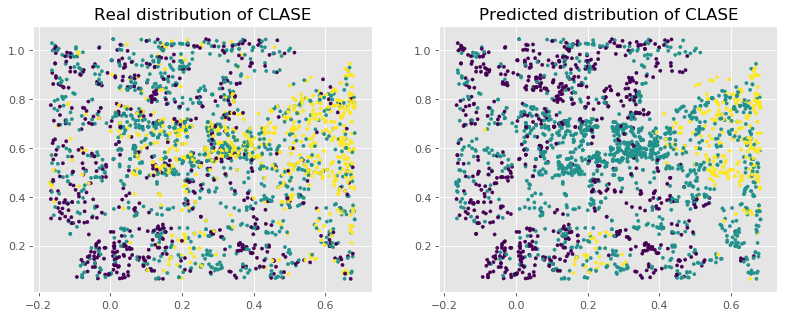

In [97]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_lr_small.astype(int));

#### SVM

In [101]:
#Scores with all features
print("- Train set results:")
evaluate(y_train, y_pred_train_sv)
print("- Test set results:")
evaluate(y_test, y_pred_test_sv)

- Train set results:
accuracy: 0.5929427529219087
precision: 0.559322033898305
recall: 0.5639097744360902
f1 score: 0.5616065350578625
- Test set results:
accuracy: 0.5195103289977047
precision: 0.4977497749774977
recall: 0.4808695652173913
f1 score: 0.4891640866873065


In [98]:
sv.fit(X_train_small,y_train)
y_pred_train_sv_small = sv.predict(X_train_small)
y_pred_test_sv_small = sv.predict(X_test_small)
print("- Train set results:")
evaluate(y_train, y_pred_train_sv_small)
print("- Test set results:")
evaluate(y_test, y_pred_test_sv_small)

C:\Users\usuario\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


- Train set results:
accuracy: 0.5753740787612596
precision: 0.5386814364838306
recall: 0.5152084757347916
f1 score: 0.5266835531487466
- Test set results:
accuracy: 0.5015302218821729
precision: 0.4743687834736037
recall: 0.5391304347826087
f1 score: 0.5046805046805046


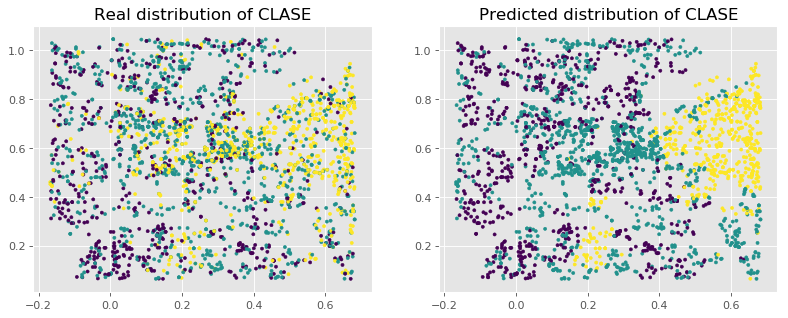

In [99]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_sv_small.astype(int));

#### Decision Trees

In [102]:
#Scores with all features
print("- Train set results:")
evaluate(y_train, y_pred_train_tree)
print("- Test set results:")
evaluate(y_test, y_pred_test_tree)

- Train set results:
accuracy: 0.5707585796173602
precision: 0.5135576198845092
recall: 0.6990772385509227
f1 score: 0.5921262121870025
- Test set results:
accuracy: 0.5145371078806427
precision: 0.47564935064935066
recall: 0.7643478260869565
f1 score: 0.5863909272848566


In [103]:
tree=DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)
tree.fit(X_train_small,y_train)
y_pred_train_tree_small = tree.predict(X_train_small)
y_pred_test_tree_small = tree.predict(X_test_small)
print("- Train set results:")
evaluate(y_train, y_pred_train_tree_small)
print("- Test set results:")
evaluate(y_test, y_pred_test_tree_small)

- Train set results:
accuracy: 0.5707585796173602
precision: 0.5135576198845092
recall: 0.6990772385509227
f1 score: 0.5921262121870025
- Test set results:
accuracy: 0.5145371078806427
precision: 0.47564935064935066
recall: 0.7643478260869565
f1 score: 0.5863909272848566


Exctly the same results.

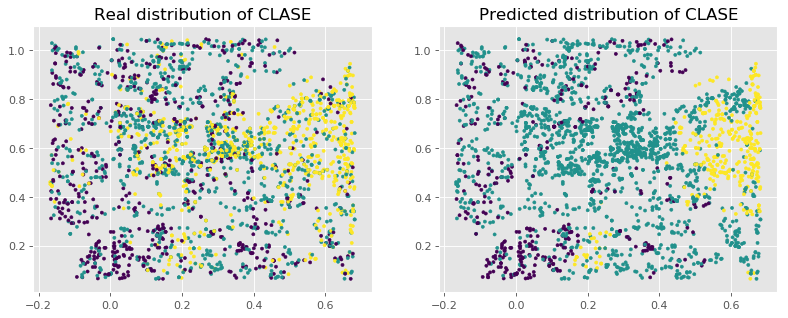

In [104]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_tree_small.astype(int));

#### NN

In [105]:
X_train_nn_small = small_data.loc[ (((small_data['LONGITUD'] > -70.58) | (small_data['LONGITUD'] < -70.72)) | ((small_data['LATITUD'] > -33.38) | (small_data['LATITUD'] < -33.52)))]

X_val_nn_small = small_data.loc[ (((small_data['LONGITUD'] > -70.6) | (small_data['LONGITUD'] < -70.7)) |
                               (small_data['LATITUD'] > -33.4) | (small_data['LATITUD'] < -33.5)) &
                             (((small_data['LONGITUD'] < -70.58) & (small_data['LONGITUD'] > -70.72)) & 
                              ((small_data['LATITUD'] < -33.38) & (small_data['LATITUD'] > -33.52)))]

X_test_nn_small = small_data.loc[ ((small_data['LONGITUD'] < -70.6) & (small_data['LONGITUD'] > -70.7)) & (small_data['LATITUD'] < -33.4) & (small_data['LATITUD'] > -33.5)]

print("Num train examples:", len(y_train_nn))
print("Num validation examples:", len(y_val_nn))
print("Num test examples:", len(y_test_nn))

Num train examples: 11223
Num validation examples: 2210
Num test examples: 2614


In [106]:
X_train_nn_small = X_train_nn_small.drop(['LONGITUD', 'LATITUD'], axis = 1)
X_val_nn_small = X_val_nn_small.drop(['LONGITUD', 'LATITUD'], axis = 1)
X_test_nn_small = X_test_nn_small.drop(['LONGITUD', 'LATITUD'], axis = 1)

In [107]:
# standardize data
X_mean = X_train_nn_small.mean(axis=0)
X_std = X_train_nn_small.std(axis=0)
X_train_nn_small = (X_train_nn_small - X_mean) / X_std
X_val_nn_small = (X_val_nn_small - X_mean) / X_std
X_test_nn_small = (X_test_nn_small - X_mean) / X_std

In [111]:
## evaluate predictions all features
print("- Train set results:")
evaluate(y_val_nn.astype(str), y_pred_val_nnm_.astype(str))
print("- Test set results:")
evaluate(y_test_nn.astype(str), y_pred_test_nnm_.astype(str))

- Train set results:
accuracy: 0.5746606334841629
precision: 0.49495875343721357
recall: 0.5993340732519423
f1 score: 0.5421686746987953
- Test set results:
accuracy: 0.5221882172915072
precision: 0.49112845990063875
recall: 0.6017391304347826
f1 score: 0.5408362641656898


In [112]:
# define the keras model
nnms = Sequential()
nnms.add(Dense(100,activation='relu',input_shape=(7,)))
nnms.add(Dropout(0.5))
nnms.add(Dense(70,activation='relu'))
nnms.add(Dropout(0.5))
nnms.add(Dense(40,activation='relu'))
nnms.add(Dropout(0.5))
nnms.add(Dense(3,activation='softmax'))

# compile the keras model
nnms.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# fit the keras model on the dataset
nnms.fit(X_train_nn_small, y_train_dummies, epochs=50, batch_size=1024, validation_data=(X_val_nn_small,y_val_dummies))

# evaluate the keras model
y_pred_val_nnm_small = nnms.predict(X_val_nn_small)
y_pred_test_nnm_small = nnms.predict(X_test_nn_small)

max_num_val = y_pred_val_nnm_small.max(axis=1)
max_nums_val = np.matrix([max_num_val, max_num_val, max_num_val]).transpose()
y_pred_val_nnm_small = (y_pred_val_nnm_small >= max_nums_val).astype(int)

max_num_test = y_pred_test_nnm_small.max(axis=1)
max_nums_test = np.matrix([max_num_test, max_num_test, max_num_test]).transpose()
y_pred_test_nnm_small = (y_pred_test_nnm_small >= max_nums_test).astype(int)

y_pred_val_nnm_df = pd.DataFrame(y_pred_val_nnm_small, columns=['1', '2', '3'])
y_pred_test_nnm_df = pd.DataFrame(y_pred_test_nnm_small, columns=['1', '2', '3'])
y_pred_val_nnm_small_ = y_pred_val_nnm_df.idxmax(axis=1)
y_pred_test_nnm_small_ = y_pred_test_nnm_df.idxmax(axis=1)

## evaluate predictions
print("- Train set results:")
evaluate(y_val_nn.astype(str), y_pred_val_nnm_small_.astype(str))
print("- Test set results:")
evaluate(y_test_nn.astype(str), y_pred_test_nnm_small_.astype(str))

Train on 11223 samples, validate on 2210 samples
Epoch 1/50
11223/11223 [==============================] - 0s 32us/step - loss: 1.0599 - accuracy: 0.4302 - val_loss: 0.9690 - val_accuracy: 0.5226
Epoch 2/50
11223/11223 [==============================] - 0s 10us/step - loss: 0.9904 - accuracy: 0.4791 - val_loss: 0.9230 - val_accuracy: 0.5303
Epoch 3/50
11223/11223 [==============================] - 0s 10us/step - loss: 0.9622 - accuracy: 0.4865 - val_loss: 0.8962 - val_accuracy: 0.5430
Epoch 4/50
11223/11223 [==============================] - 0s 10us/step - loss: 0.9462 - accuracy: 0.4925 - val_loss: 0.8825 - val_accuracy: 0.5385
Epoch 5/50
11223/11223 [==============================] - 0s 10us/step - loss: 0.9319 - accuracy: 0.4987 - val_loss: 0.8724 - val_accuracy: 0.5376
Epoch 6/50
11223/11223 [==============================] - 0s 10us/step - loss: 0.9196 - accuracy: 0.5006 - val_loss: 0.8636 - val_accuracy: 0.5430
Epoch 7/50
11223/11223 [==============================] - 0s 10us/ste

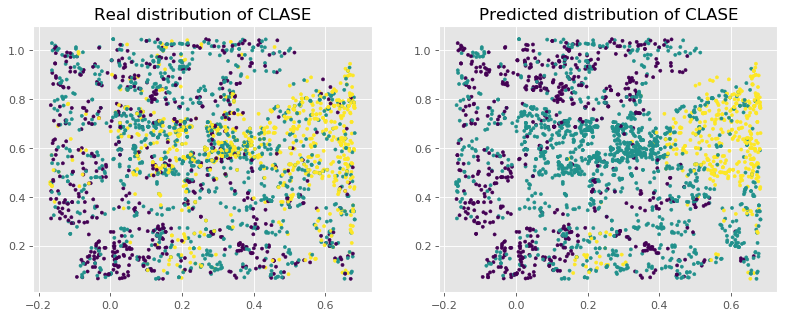

In [113]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_nnm_small_.astype(int));

Predictions have improved a bit. When visualizing, the representations are very similar for all the models. There is no big difference in the predictions of the different models.

### 3.3 Dimensionality reduction

Now, we will try a dimensionality reduction of the dataset. We will reduce the dimension to 7 since that was the number of features used in the previous point. This is the same dimension as before, but different data values because they will be determined to take into account all features of the dataset.

In [114]:
pca = decomposition.PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca)

In [115]:
X_train_pca.head()

0         1         2         3         4         5         6
0  6.220945  1.613888 -0.309601  1.525186 -0.703686  0.119678  1.021874
1  5.974612  1.644017 -0.383022  1.469366 -0.518479  0.286816  1.006012
2  7.533710  2.109345  0.270692  2.004366 -0.731286 -0.120546  1.573945
3  7.527765  2.125839  0.267949  1.998379 -0.726224 -0.113900  1.584210
4  6.150878  1.377533 -0.394357  1.666673 -0.590049  0.158248  0.767527

#### Logistic regression

In [116]:
#Scores with all features
print("- Train set results:")
evaluate(y_train, y_pred_train_lr)
print("- Test set results:")
evaluate(y_test, y_pred_test_lr)

- Train set results:
accuracy: 0.5863917218789548
precision: 0.544043144304625
recall: 0.5688653451811346
f1 score: 0.5561774287862334
- Test set results:
accuracy: 0.49273144605967867
precision: 0.4690346083788707
recall: 0.44782608695652176
f1 score: 0.45818505338078297


In [117]:
#Scores with 7 features
print("- Train set results:")
evaluate(y_train, y_pred_train_lr_small)
print("- Test set results:")
evaluate(y_test, y_pred_test_lr_small)

- Train set results:
accuracy: 0.5707585796173602
precision: 0.5283114256825076
recall: 0.5357142857142857
f1 score: 0.5319871033429493
- Test set results:
accuracy: 0.4797245600612089
precision: 0.4521795705920625
recall: 0.6043478260869565
f1 score: 0.5173055452177149


In [118]:
# estimate model on trainset
lr.fit(X_train_pca, y_train)

# make predictions
y_pred_train_lr_pca = lr.predict(X_train_pca)
y_pred_test_lr_pca = lr.predict(X_test_pca)

print("- Train set results:")
evaluate(y_train, y_pred_train_lr_pca)
print("- Test set results:")
evaluate(y_test, y_pred_test_lr_pca)

- Train set results:
accuracy: 0.5441822377726494
precision: 0.5070640937284632
recall: 0.502904989747095
f1 score: 0.5049759780370624
- Test set results:
accuracy: 0.495026778882938
precision: 0.4731774415405777
recall: 0.5982608695652174
f1 score: 0.5284178187403994


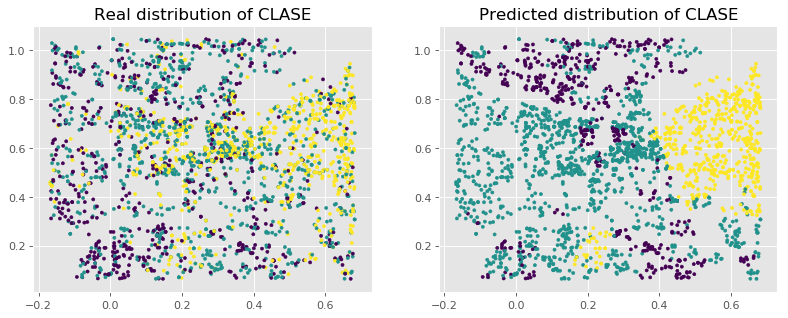

In [119]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_lr_pca);

#### SVM

In [120]:
#Scores with all features
print("- Train set results:")
evaluate(y_train, y_pred_train_sv)
print("- Test set results:")
evaluate(y_test, y_pred_test_sv)

- Train set results:
accuracy: 0.5929427529219087
precision: 0.559322033898305
recall: 0.5639097744360902
f1 score: 0.5616065350578625
- Test set results:
accuracy: 0.5195103289977047
precision: 0.4977497749774977
recall: 0.4808695652173913
f1 score: 0.4891640866873065


In [121]:
#Scores with 7 features
print("- Train set results:")
evaluate(y_train, y_pred_train_sv_small)
print("- Test set results:")
evaluate(y_test, y_pred_test_sv_small)

- Train set results:
accuracy: 0.5753740787612596
precision: 0.5386814364838306
recall: 0.5152084757347916
f1 score: 0.5266835531487466
- Test set results:
accuracy: 0.5015302218821729
precision: 0.4743687834736037
recall: 0.5391304347826087
f1 score: 0.5046805046805046


In [122]:
sv.fit(X_train_pca,y_train)
y_pred_train_sv_pca = sv.predict(X_train_pca)
y_pred_test_sv_pca = sv.predict(X_test_pca)
print("- Train set results:")
evaluate(y_train, y_pred_train_sv_pca)
print("- Test set results:")
evaluate(y_test, y_pred_test_sv_pca)

C:\Users\usuario\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


- Train set results:
accuracy: 0.5846795205836373
precision: 0.5539052944260003
recall: 0.5416951469583049
f1 score: 0.547732181425486
- Test set results:
accuracy: 0.5263963274674828
precision: 0.5003897116134061
recall: 0.5582608695652174
f1 score: 0.5277435265104808


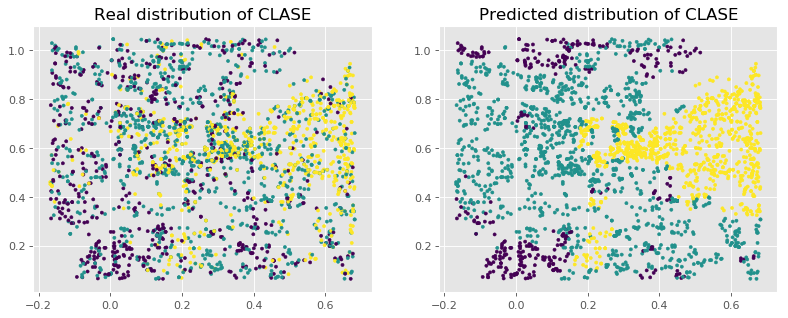

In [123]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_sv_pca);

#### Decision tree

- Decision trees tend to overfit on data with a large number of features. Getting the right ratio of samples to number of features is important since a tree with few samples in high dimensional space is very likely to overfit.
- Consider performing dimensionality reduction (PCA, ICA, or Feature selection) beforehand to give your tree a better chance of finding features that are discriminative.

In [124]:
#Scores with all features
print("- Train set results:")
evaluate(y_train, y_pred_train_tree)
print("- Test set results:")
evaluate(y_test, y_pred_test_tree)

- Train set results:
accuracy: 0.5707585796173602
precision: 0.5135576198845092
recall: 0.6990772385509227
f1 score: 0.5921262121870025
- Test set results:
accuracy: 0.5145371078806427
precision: 0.47564935064935066
recall: 0.7643478260869565
f1 score: 0.5863909272848566


In [125]:
#Scores with 7 features
print("- Train set results:")
evaluate(y_train, y_pred_train_tree_small)
print("- Test set results:")
evaluate(y_test, y_pred_test_tree_small)

- Train set results:
accuracy: 0.5707585796173602
precision: 0.5135576198845092
recall: 0.6990772385509227
f1 score: 0.5921262121870025
- Test set results:
accuracy: 0.5145371078806427
precision: 0.47564935064935066
recall: 0.7643478260869565
f1 score: 0.5863909272848566


In [126]:
tree=DecisionTreeClassifier(max_depth = 7)
tree.fit(X_train_pca,y_train)
y_pred_train_tree_pca = tree.predict(X_train_pca)
y_pred_test_tree_pca = tree.predict(X_test_pca)
print("- Train set results:")
evaluate(y_train, y_pred_train_tree_pca)
print("- Test set results:")
evaluate(y_test, y_pred_test_tree_pca)

- Train set results:
accuracy: 0.5941338494751731
precision: 0.5584935897435898
recall: 0.5955228981544771
f1 score: 0.5764141581210719
- Test set results:
accuracy: 0.473221117061974
precision: 0.4574607329842932
recall: 0.6078260869565217
f1 score: 0.5220313666915608


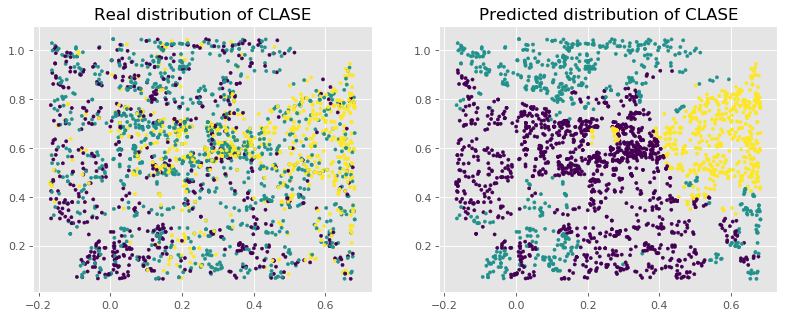

In [134]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_tree_pca);

#### NN

In [135]:
## evaluate predictions all features
print("- Train set results:")
evaluate(y_val_nn.astype(str), y_pred_val_nnm_.astype(str))
print("- Test set results:")
evaluate(y_test_nn.astype(str), y_pred_test_nnm_.astype(str))

- Train set results:
accuracy: 0.5746606334841629
precision: 0.49495875343721357
recall: 0.5993340732519423
f1 score: 0.5421686746987953
- Test set results:
accuracy: 0.5221882172915072
precision: 0.49112845990063875
recall: 0.6017391304347826
f1 score: 0.5408362641656898


In [136]:
## evaluate predictions 7 features
print("- Train set results:")
evaluate(y_val_nn.astype(str), y_pred_val_nnm_small_.astype(str))
print("- Test set results:")
evaluate(y_test_nn.astype(str), y_pred_test_nnm_small_.astype(str))

- Train set results:
accuracy: 0.5746606334841629
precision: 0.49899598393574296
recall: 0.5516093229744728
f1 score: 0.5239852398523985
- Test set results:
accuracy: 0.509946442234124
precision: 0.4765013054830287
recall: 0.6347826086956522
f1 score: 0.5443698732289336


In [137]:
X_train_nn_pca = pca.transform(X_train_nn)
X_train_nn_pca = pd.DataFrame(X_train_nn_pca)
X_val_nn_pca = pca.transform(X_val_nn)
X_val_nn_pca = pd.DataFrame(X_val_nn_pca)
X_test_nn_pca = pca.transform(X_test_nn)
X_test_nn_pca = pd.DataFrame(X_test_nn_pca)

In [138]:
nnms = Sequential()
nnms.add(Dense(30,activation='relu',input_shape=(7,)))
nnms.add(Dropout(0.5))
#nnms.add(Dense(20,activation='relu'))
#nnms.add(Dropout(0.5))
nnms.add(Dense(10,activation='relu'))
nnms.add(Dropout(0.5))
nnms.add(Dense(3,activation='softmax'))

# compile the keras model
nnms.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# fit the keras model on the dataset
nnms.fit(X_train_nn_pca, y_train_dummies, epochs=50, batch_size=1024, validation_data=(X_val_nn_pca,y_val_dummies))

# evaluate the keras model
y_pred_val_nnm_pca = nnms.predict(X_val_nn_pca)
y_pred_test_nnm_pca = nnms.predict(X_test_nn_pca)

max_num_val = y_pred_val_nnm_pca.max(axis=1)
max_nums_val = np.matrix([max_num_val, max_num_val, max_num_val]).transpose()
y_pred_val_nnm_pca = (y_pred_val_nnm_pca >= max_nums_val).astype(int)

max_num_test = y_pred_test_nnm_pca.max(axis=1)
max_nums_test = np.matrix([max_num_test, max_num_test, max_num_test]).transpose()
y_pred_test_nnm_pca = (y_pred_test_nnm_pca >= max_nums_test).astype(int)

y_pred_val_nnm_df = pd.DataFrame(y_pred_val_nnm_pca, columns=['1', '2', '3'])
y_pred_test_nnm_df = pd.DataFrame(y_pred_test_nnm_pca, columns=['1', '2', '3'])
y_pred_val_nnm_pca_ = y_pred_val_nnm_df.idxmax(axis=1)
y_pred_test_nnm_pca_ = y_pred_test_nnm_df.idxmax(axis=1)

## evaluate predictions
print("- Train set results:")
evaluate(y_val_nn.astype(str), y_pred_val_nnm_pca_.astype(str))
print("- Test set results:")
evaluate(y_test_nn.astype(str), y_pred_test_nnm_pca_.astype(str))

Train on 11223 samples, validate on 2210 samples
Epoch 1/50
11223/11223 [==============================] - 0s 18us/step - loss: 1.8854 - accuracy: 0.4117 - val_loss: 1.4721 - val_accuracy: 0.4077
Epoch 2/50
11223/11223 [==============================] - 0s 5us/step - loss: 1.5764 - accuracy: 0.4211 - val_loss: 1.2500 - val_accuracy: 0.4072
Epoch 3/50
11223/11223 [==============================] - 0s 5us/step - loss: 1.3962 - accuracy: 0.4191 - val_loss: 1.1152 - val_accuracy: 0.4063
Epoch 4/50
11223/11223 [==============================] - 0s 4us/step - loss: 1.2730 - accuracy: 0.4273 - val_loss: 1.0374 - val_accuracy: 0.4176
Epoch 5/50
11223/11223 [==============================] - 0s 5us/step - loss: 1.1924 - accuracy: 0.4349 - val_loss: 0.9977 - val_accuracy: 0.4403
Epoch 6/50
11223/11223 [==============================] - 0s 5us/step - loss: 1.1573 - accuracy: 0.4308 - val_loss: 0.9836 - val_accuracy: 0.4493
Epoch 7/50
11223/11223 [==============================] - 0s 4us/step - lo

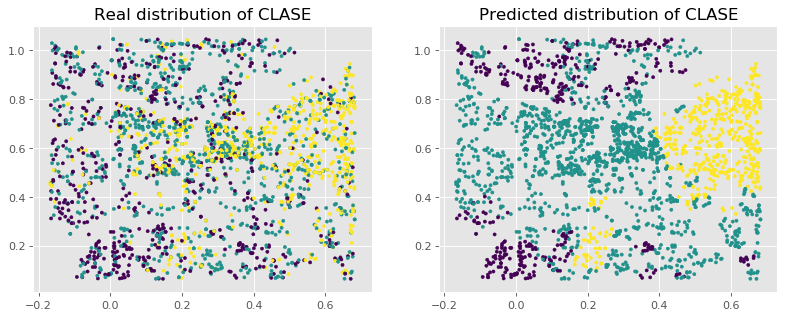

In [139]:
plt.figure(figsize=(12,15), dpi= 80)
plt.subplot(321)
plt.title('Real distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_test)
plt.subplot(322)
plt.title('Predicted distribution of CLASE', fontsize=15)
plt.scatter(X_test['LONGITUD'], X_test['LATITUD'], s=8, c=y_pred_test_nnm_pca_.astype(int));

For all models but Classification trees, the performance with the dimension reduced dataset with PCA is better than with the other datasets used. This can be possible if the way how the values of the previous dataset are transformed, so the models can interpret them better. However, when visualizing the results, the separation of the classes is very delimitated when the real values are mixed between them.

## 4. Conclusions

What can be determined after all the calculations we have done and how we have transformed the data is that having a big dataset is not always the best option. What is important is that the features that you give to the model give the right information about the target variable in order to the model be capable of interpreting it in the right way. 

Having avery different train and test sets may result in unsatisfactory predictions. As we have seen in this case, our models have not been able to get 60% of the predictions right. Classifications help the models to perform better, but for this case, adding more data would have been useful to determine a set of characteristics that give the right information about the type of classes.

In any case, the purpose from the beginning has been completed, as the analysis of the models demonstrates the power of applying BA tools and concepts for understanding complex architectures of data like this one.

##### Contributions: This project has been realized equaly by the students Betlem Aguado (s182245) and Ignacio Agudo (s185227). All  parts  have  been  solved,  coded  and written together.